# Comparing M6A ML models (HIFI read models)

In [4]:
# Get all the requisite imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import pandas as pd
import requests
import io
import xgboost as xgb 
from m6a_calling import M6ANet
from torchsummary import summary

from sklearn.metrics import (confusion_matrix,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             balanced_accuracy_score,
                             matthews_corrcoef,
                             roc_auc_score,
                             average_precision_score,
                             roc_curve,
                             precision_recall_curve
                             )

### Read in the HiFi test data

In [ ]:
# HiFi data

data_path = "../data/deprecated-data-2022-10-19/m6A_test_other_half_hifi.npz"

train_val_data = np.load(data_path, allow_pickle=True)

# Get the dictionary from the containing relevant data
train_val_data = train_val_data['save_data_dict'][()]

# Load test features and labels
X_test = train_val_data['X_test']
y_test = train_val_data['y_test']

### Predict using the CNN model

In [ ]:
m6a_model = torch.load("models/m6ANet_PS00075_no_init.3.best.torch", map_location=torch.device('cpu'))

X_test = torch.Tensor(X_test)
test_pred_cnn = m6a_model.predict(X_test, device='cpu').detach().numpy()

### Predict using the XGBoost model

In [ ]:
bst2 = xgb.Booster({'nthread': 4})  # init model
bst2.load_model('models/xgboost.otherhalf.hifi.100rds.json')  # load data

X_test_2d = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

dtest = xgb.DMatrix(X_test_2d)
test_pred_xgb = bst2.predict(dtest)

### Plot ROC curve for XGBoost and CNN models

In [ ]:
plt.figure(figsize=(10,5))
plt.axline([0,0], slope=1, c="black")

fpr, tpr, thresholds = metrics.roc_curve(y_test[:, 0], test_pred_cnn[:, 0], pos_label=1)
print(f"AUC-ROC CNN: {metrics.auc(fpr, tpr):.03f}")
plt.plot(fpr, tpr, c='gray', label=f"CNN-AUROC: {metrics.auc(fpr, tpr):.04f}")

fpr, tpr, thresholds = metrics.roc_curve(y_test[:, 0], test_pred_xgb, pos_label=1)
print(f"AUC-ROC XGBoost: {metrics.auc(fpr, tpr):.03f}")
plt.plot(fpr, tpr, c='blue', label=f"XGBoost-AUROC: {metrics.auc(fpr, tpr):.04f}")


plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
#plt.xlim([-0.1, 1.1])
#plt.ylim([0, 1.1])
plt.tight_layout()
plt.savefig("figures/roc_compare_hifi.png")
plt.plot()


### Focus on 1% FPR with the ROC curve

In [ ]:
plt.figure(figsize=(10,5))
#plt.axline([0,0], slope=1, c="black")

fpr, tpr, thresholds = metrics.roc_curve(y_test[:, 0], test_pred_cnn[:, 0], pos_label=1)

idx_fpr = np.where(fpr <= 0.050)[0]

thr_last = thresholds[idx_fpr][-1]

print(f"AUC-ROC CNN: {metrics.auc(fpr, tpr):.04f}")
plt.plot(fpr[idx_fpr], tpr[idx_fpr], c='gray', label=f"CNN-AUROC: {metrics.auc(fpr, tpr):.04f}")

fpr, tpr, thresholds = metrics.roc_curve(y_test[:, 0], test_pred_xgb, pos_label=1)
idx_fpr = np.where(fpr <= 0.050)[0]

thr_last = thresholds[idx_fpr][-1]

print(f"AUC-ROC XGBoost: {metrics.auc(fpr, tpr):.04f}")
plt.plot(fpr[idx_fpr], tpr[idx_fpr], c='blue', label=f"XGBoost-AUROC: {metrics.auc(fpr, tpr):.04f}")


plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
#plt.xlim([-0.1, 1.1])
#plt.ylim([0, 1.1])
plt.tight_layout()
plt.savefig("figures/roc_compare_hifi_fdr_1.png")
plt.plot()


### Plot the PR curve using XGBoost and CNN predictions on HiFi data

In [ ]:
plt.figure(figsize=(8,5))
plt.axline([0,0], slope=1, c="white")
plt.axline([0,1], slope=-1, c="black")
precision, recall, thresholds = metrics.precision_recall_curve(y_test[:, 0], test_pred_cnn[:, 0], pos_label=1)
print(f"AU-PR CNN: {metrics.average_precision_score(y_test[:, 0], test_pred_cnn[:, 0])}")
plt.plot(recall, precision, c='gray', label=f"CNN-AUPR: {metrics.average_precision_score(y_test[:, 0], test_pred_cnn[:, 0]):.03f}")

precision, recall, thresholds = metrics.precision_recall_curve(y_test[:, 0], test_pred_xgb, pos_label=1)
print(f"AU-PR XGBoost: {metrics.average_precision_score(y_test[:, 0], test_pred_xgb)}")
plt.plot(recall, precision, c='blue', label=f"XGBoost-AUPR: {metrics.average_precision_score(y_test[:, 0], test_pred_xgb):.03f}")


plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("PR curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.tight_layout()
plt.savefig("figures/pr_compare_hifi.png")
plt.plot()

### Save model for RUST

In [ ]:
m6a_model = torch.load("models/m6ANet_PS00075.best.torch", map_location=torch.device('cpu'))
example = torch.rand(1, 6, 15)
traced_script_module = torch.jit.trace(m6a_model, example)
traced_script_module.save("models/m6ANet_PS00075.best.torch.pt")


In [ ]:
m6a_model = torch.load("models/m6ANet_other_half_hifi.3.best.torch", map_location=torch.device('cpu'))
example = torch.rand(1, 6, 15)
traced_script_module = torch.jit.trace(m6a_model, example)
traced_script_module.save("models/m6ANet_other_half_hifi.3.best.torch_nn.pt")


## Test on different data

In [ ]:
val_path = "/net/noble/vol4/noble/user/anupamaj/proj/m6A-calling/data/PS00075_2_2022-10-17.npz"
input_size = 6
# Load validation data
val_data = np.load(val_path, allow_pickle=True)
X_val = val_data['features'][:, 0:input_size, :]
y_val = val_data['labels']
    
y_val_ohe = np.zeros((len(y_val), 2))
y_val_ohe[np.where(y_val == 1)[0], 0] = 1
y_val_ohe[np.where(y_val == 0)[0], 1] = 1

In [ ]:
m6a_model = torch.load("models/m6ANet_PS00075_no_init.3.best.torch")
#, map_location=torch.device('cpu')
# Print model architecture summary
summary_str = summary(m6a_model, input_size=(6, 15))

X_val = torch.Tensor(X_val)
val_pred_cnn = m6a_model.predict(X_val, device='cpu').detach().numpy()

In [ ]:
bst2 = xgb.Booster({'nthread': 4})  # init model
bst2.load_model('models/xgboost.otherhalf.hifi.100rds.json')  # load data

X_val_2d = X_val.reshape(X_val.shape[0], X_val.shape[1] * X_val.shape[2])

dval = xgb.DMatrix(X_val_2d)
val_pred_xgb = bst2.predict(dval)

In [ ]:
plt.figure(figsize=(10,5))
plt.axline([0,0], slope=1, c="black")

fpr, tpr, thresholds = metrics.roc_curve(y_val_ohe[:, 0], val_pred_cnn[:, 0], pos_label=1)
print(f"AUC-ROC CNN: {metrics.auc(fpr, tpr):.03f}")
plt.plot(fpr, tpr, c='gray', label=f"CNN-AUROC: {metrics.auc(fpr, tpr):.04f}")


plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
#plt.xlim([-0.1, 1.1])
#plt.ylim([0, 1.1])
plt.tight_layout()
plt.savefig("figures/roc_compare_hifi_PS00075.png")
plt.plot()


In [ ]:
plt.figure(figsize=(10,5))
#plt.axline([0,0], slope=1, c="black")

fpr, tpr, thresholds = metrics.roc_curve(y_val_ohe[:, 0], val_pred_cnn[:, 0], pos_label=1)

idx_fpr = np.where(fpr <= 0.050)[0]

thr_last = thresholds[idx_fpr][-1]
print(thresholds[idx_fpr])

print(thr_last)

print(f"AUC-ROC CNN: {metrics.auc(fpr, tpr):.04f}")
plt.plot(fpr[idx_fpr], tpr[idx_fpr], c='gray', label=f"CNN-AUROC: {metrics.auc(fpr, tpr):.04f}")


plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
#plt.xlim([-0.1, 1.1])
#plt.ylim([0, 1.1])
plt.tight_layout()
plt.savefig("figures/roc_compare_hifi_fdr_1_PS00075.png")
plt.plot()


In [ ]:
plt.figure(figsize=(8,5))
plt.axline([0,0], slope=1, c="white")
plt.axline([0,1], slope=-1, c="black")
precision, recall, thresholds = metrics.precision_recall_curve(y_val_ohe[:, 0], val_pred_cnn[:, 0], pos_label=1)
print(f"AU-PR CNN: {metrics.average_precision_score(y_val_ohe[:, 0], val_pred_cnn[:, 0])}")
plt.plot(recall, precision, c='gray', label=f"CNN-AUPR: {metrics.average_precision_score(y_val_ohe[:, 0], val_pred_cnn[:, 0]):.03f}")


plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("PR curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.tight_layout()
plt.savefig("figures/pr_compare_hifi_PS00075.png")
plt.plot()

In [ ]:
plt.figure(figsize=(8,5))
#plt.axline([0,0], slope=1, c="white")
#plt.axline([0,1], slope=-1, c="black")
precision, recall, thresholds = metrics.precision_recall_curve(y_val_ohe[:, 0], val_pred_cnn[:, 0], pos_label=1)
print(len(precision), len(thresholds))
print(f"AU-PR CNN: {metrics.average_precision_score(y_val_ohe[:, 0], val_pred_cnn[:, 0])}")
plt.plot(thresholds, precision[1:], c='gray', label=f"threshold vs precision")
plt.plot(thresholds, recall[1:], c='red', label=f"threshold vs recall")


plt.legend(bbox_to_anchor=(1.1, 1.05))
#plt.title("threshold vs precision")
plt.xlabel("thresholds")
#plt.ylabel("Precision")
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.tight_layout()
plt.savefig("figures/pr_compare_hifi_PS00075.png")
plt.plot()

## Save the 2.0 chemistry supervised model

In [ ]:
m6a_model = torch.load("models/m6ANet_PS00075_no_init.3.best.torch", map_location=torch.device('cpu'))
example = torch.rand(1, 6, 15)
traced_script_module = torch.jit.trace(m6a_model, example)
traced_script_module.save("models/m6ANet_PS00075_no_init.3.best.torch.pt")


## Save the 2.2 chemistry supervised model

In [ ]:
m6a_model = torch.load("models/m6ANet_PS00109_no_init.3.best.torch", map_location=torch.device('cpu'))
example = torch.rand(1, 6, 15)
traced_script_module = torch.jit.trace(m6a_model, example)
traced_script_module.save("models/m6ANet_PS00109_no_init.3.best.torch.pt")

## Save the 2.0 semi-supervised model

In [100]:
m6a_model = torch.load("models/m6ANet_PS00075_no_init.3.best_semi-supervised.torch", map_location=torch.device('cpu'))
example = torch.rand(1, 6, 15)
traced_script_module = torch.jit.trace(m6a_model, example)
traced_script_module.save("models/m6ANet_PS00075_no_init.3.best_semi-supervised.torch.pt")

## Save the 2.2 chemistry semi-supervised model

In [101]:
m6a_model = torch.load("models/m6ANet_PS00109_no_init.3.best_semi-supervised.torch", map_location=torch.device('cpu'))
example = torch.rand(1, 6, 15)
traced_script_module = torch.jit.trace(m6a_model, example)
traced_script_module.save("models/m6ANet_PS00109_no_init.3.best_semi-supervised.torch.pt")

## Test the semi-supervised model

### Save 1% of the data as validation set. 

In [ ]:
import numpy as np

val_path = "/net/noble/vol4/noble/user/anupamaj/proj/m6A-calling/data/PS00075_1.npz"

input_size=6

val_data = np.load(val_path, allow_pickle=True)
X_val = val_data['features'][:, 0:input_size, :]
y_val = val_data['labels']

# Take 1% val labels
rand_val = np.random.choice(np.arange(len(y_val), dtype=int), size=(int(0.1 * len(y_val)),), replace=False)

X_val = X_val[rand_val, :, :]
y_val = y_val[rand_val]

save_path = "/net/noble/vol4/noble/user/anupamaj/proj/m6A-calling/data/PS00075_1_10percent.npz"

np.savez(save_path, X_val=X_val, y_val=y_val)
print(f"Validation features shape {X_val.shape}, validation labels shape: {y_val.shape}")

### Load 1% val data

In [72]:
load_path = "/net/noble/vol4/noble/user/anupamaj/proj/m6A-calling/data/PS00075_1_10percent.npz"
val_data = np.load(load_path, allow_pickle=True)

X_val = val_data['X_val']
y_val = val_data['y_val']

X_val = torch.Tensor(X_val)

In [73]:
y_val_ohe = np.zeros((len(y_val), 2))
y_val_ohe[np.where(y_val == 1)[0], 0] = 1
y_val_ohe[np.where(y_val == 0)[0], 1] = 1

### predict using the CNN model

In [92]:
m6a_model = torch.load("models/m6ANet_PS00075_no_init.3.best_semi.torch", map_location=torch.device('cpu'))
val_pred_cnn_all = m6a_model.predict(X_val, device='cpu').detach().numpy()
val_pred_cnn = val_pred_cnn_all

In [86]:
frac = 1.0/255.0
print(f"frac: {frac}")

val_pred_cnn[val_pred_cnn[:, 0] < frac, 0] = 0

frac: 0.00392156862745098


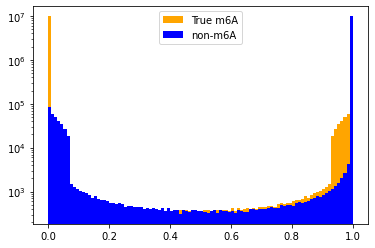

In [93]:
import matplotlib.pyplot as plt

plt.hist(val_pred_cnn[:, 0],  log=True, bins=100, color="Orange", label="True m6A")
plt.hist(val_pred_cnn[:, 1],  log=True, bins=100, color="blue", label="non-m6A")
plt.legend()
plt.show() 

In [88]:
sklearn_ap = average_precision_score(y_val, val_pred_cnn[:, 0])
print(f"Validation IPD average precision: {sklearn_ap}")

Validation IPD average precision: 0.7324980756734849


In [89]:
one = np.count_nonzero(val_pred_cnn[:, 0])
two = np.count_nonzero(val_pred_cnn[:, 1])

print(f"Number of positives: {one}, number of negatives: {two}, all= {one + two}")

Number of positives: 378241, number of negatives: 10215017, all= 10593258


In [90]:
one = np.count_nonzero(y_val_ohe[:, 0])
two = np.count_nonzero(y_val_ohe[:, 1])

print(f"Number of positives: {one}, number of negatives: {two}, , all= {one + two}")

Number of positives: 484789, number of negatives: 9730228, , all= 10215017


AU-PR CNN: 0.7324980756734849


[]

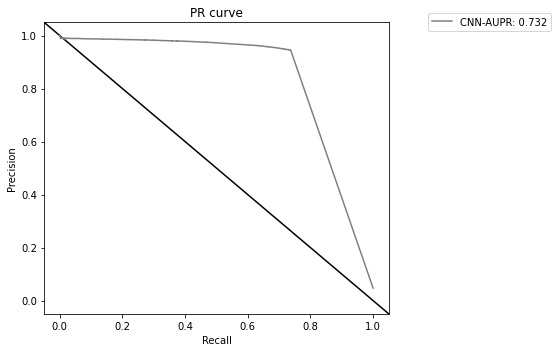

In [91]:
plt.figure(figsize=(8,5))
plt.axline([0,0], slope=1, c="white")
plt.axline([0,1], slope=-1, c="black")
precision, recall, thresholds = metrics.precision_recall_curve(y_val_ohe[:, 0], val_pred_cnn[:, 0], pos_label=1)
print(f"AU-PR CNN: {metrics.average_precision_score(y_val_ohe[:, 0], val_pred_cnn[:, 0])}")
plt.plot(recall, precision, c='gray', label=f"CNN-AUPR: {metrics.average_precision_score(y_val_ohe[:, 0], val_pred_cnn[:, 0]):.03f}")


plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("PR curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.tight_layout()
plt.savefig("figures/pr_compare_hifi_PS00075.png")
plt.plot()